In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot
import os
from copy import deepcopy

from time import time

from math import ceil
from scipy.stats import spearmanr, gamma, poisson

from anndata import AnnData, read_h5ad
import scanpy as sc
from scanpy import read
import pandas as pd

from torch.utils.data import DataLoader, TensorDataset
from torch import tensor
from torch.cuda import is_available

from sciPENN.Preprocessing import preprocess
from sciPENN.sciPENN_API import sciPENN_API

from matplotlib import colors as mcolors

In [2]:
"""Read in Raw Data"""

adata_gene = sc.read("../Data/pbmc/pbmc_gene.h5ad")
adata_protein = sc.read("../Data/pbmc/pbmc_protein.h5ad")

doublet_bool = (adata_gene.obs['celltype.l2'] != 'Doublet')

adata_gene = adata_gene[doublet_bool].copy()
adata_protein = adata_protein[doublet_bool].copy()

train_donors = ['P1', 'P3', 'P4', 'P7']
train_bools = [x in train_donors for x in adata_gene.obs['donor']]
test_bools = np.invert(train_bools)

adata_gene_test = adata_gene[test_bools].copy()
adata_protein_test = adata_protein[test_bools].copy()

adata_gene = adata_gene[train_bools].copy()
adata_protein = adata_protein[train_bools].copy()

In [3]:
# CD8 cell subpopulations
cd8_types = ['CD8 Naive', 'CD8 Naive_2', 'CD8 TCM_1', 'CD8 TCM_2', 'CD8 TCM_3', 'CD8 TEM_3', 'CD8 TEM_1', 'CD8 TEM_2', 'CD8 TEM_4', 'CD8 TEM_5', 'CD8 TEM_6', 'CD8 Proliferating']

In [4]:
feature_info = pd.read_csv('cd8features.csv')

# Remove VTCN1
for i_vtcn1, gene in enumerate(feature_info['gene_name']):
    if gene == 'VTCN1':
        break

feature_info = feature_info.drop(index = i_vtcn1)

proteins, genes, types = feature_info.to_numpy().T

In [5]:
def correct(string):
    result = []
    for char in string:
        if char != '`':
            result.append(char)
            
    return ''.join(result)

#Clean protein names so they are compatible with the data
proteins = [correct(protein) for protein in proteins]

In [6]:
# Remove lowly expressed cells
cell_filter = (adata_gene_test.X > 10**(-8)).sum(axis = 1) >= 200
tmp_gene = adata_gene_test[cell_filter].copy()
tmp_protein = adata_protein_test[cell_filter].copy()
tmp_gene.X = tmp_gene.X.toarray()
tmp_protein.X = tmp_protein.X.toarray()

# Cell and log normalize
sc.pp.normalize_total(tmp_gene)
sc.pp.log1p(tmp_gene)
sc.pp.normalize_total(tmp_protein)
sc.pp.log1p(tmp_protein)

# Z-score normalize
patients = pd.unique(tmp_gene.obs['donor'].values)
for patient in patients:
    indices = [x == patient for x in tmp_gene.obs['donor']]
    
    sub_adata = tmp_gene[indices].copy()
    sc.pp.scale(sub_adata)
    tmp_gene[indices] = sub_adata.X.copy()
    
    sub_adata = tmp_protein[indices].copy()
    sc.pp.scale(sub_adata)
    tmp_protein[indices] = sub_adata.X.copy()
    
# Retain only CD8 cells
type_key = [x in cd8_types for x in tmp_gene.obs['celltype.l3']]
tmp_gene = tmp_gene[type_key]
tmp_protein = tmp_protein[type_key]

# Full protein dataset
tmp_protein_full = tmp_protein.copy()

# Keep only relevant genes/proteins
tmp_gene = tmp_gene[:, pd.unique(genes)].copy()
tmp_protein = tmp_protein[:, proteins].copy()
    
# Get gene data
X, celltype = tmp_gene.X, tmp_gene.obs['celltype.l3'].to_numpy()[:, None]
df_gene = pd.DataFrame(np.concatenate((X, celltype), axis = 1), columns = pd.unique(genes).tolist() + ['Celltype'])
for i in range(len(df_gene.columns) - 1):
    column = df_gene.columns[i]
    df_gene[column] = pd.to_numeric(df_gene[column])
    
# Get protein data
X, celltype = tmp_protein.X, tmp_protein.obs['celltype.l3'].to_numpy()[:, None]
df_protein = pd.DataFrame(np.concatenate((X, celltype), axis = 1), columns = proteins + ['Celltype'])
for i in range(len(df_protein.columns) - 1):
    column = df_protein.columns[i]
    df_protein[column] = pd.to_numeric(df_protein[column])

<AxesSubplot:xlabel='Celltype'>

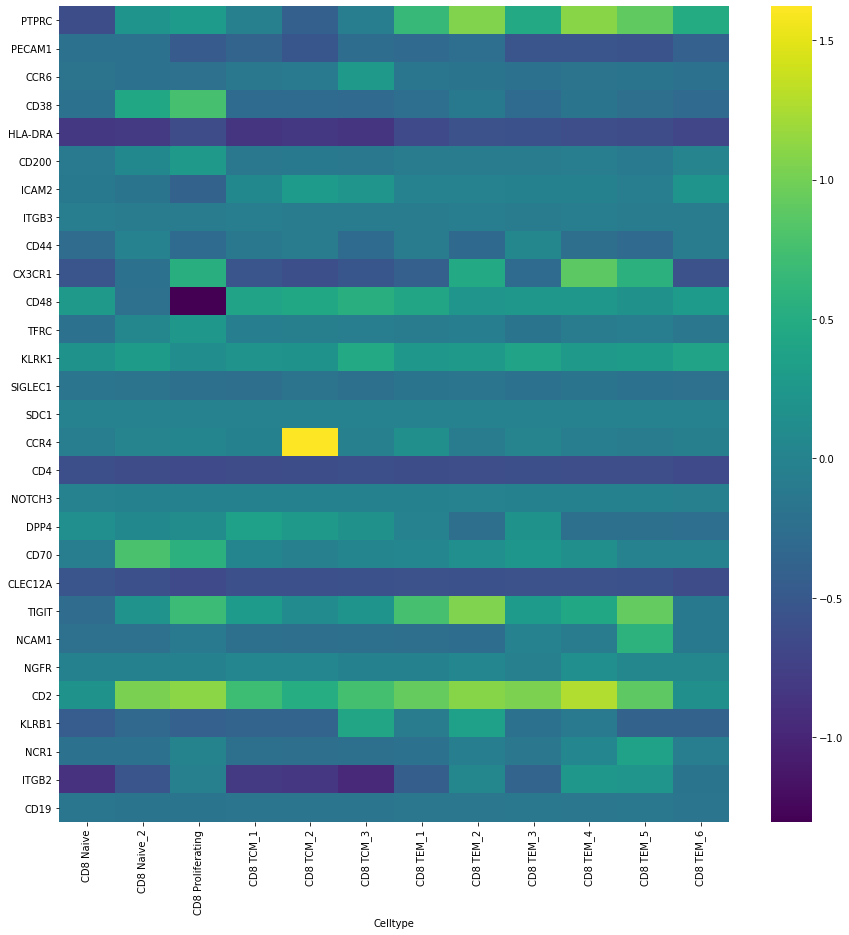

In [7]:
import seaborn as sns
from matplotlib import pyplot as plt

# Heatmap for average gene expression by celltype
fig, ax = plt.subplots(1, 1, figsize = (15, 15))
sns.heatmap(df_gene.groupby('Celltype').mean().T, yticklabels = df_gene.columns[:-1], ax = ax, cmap = 'viridis')

<AxesSubplot:xlabel='Celltype'>

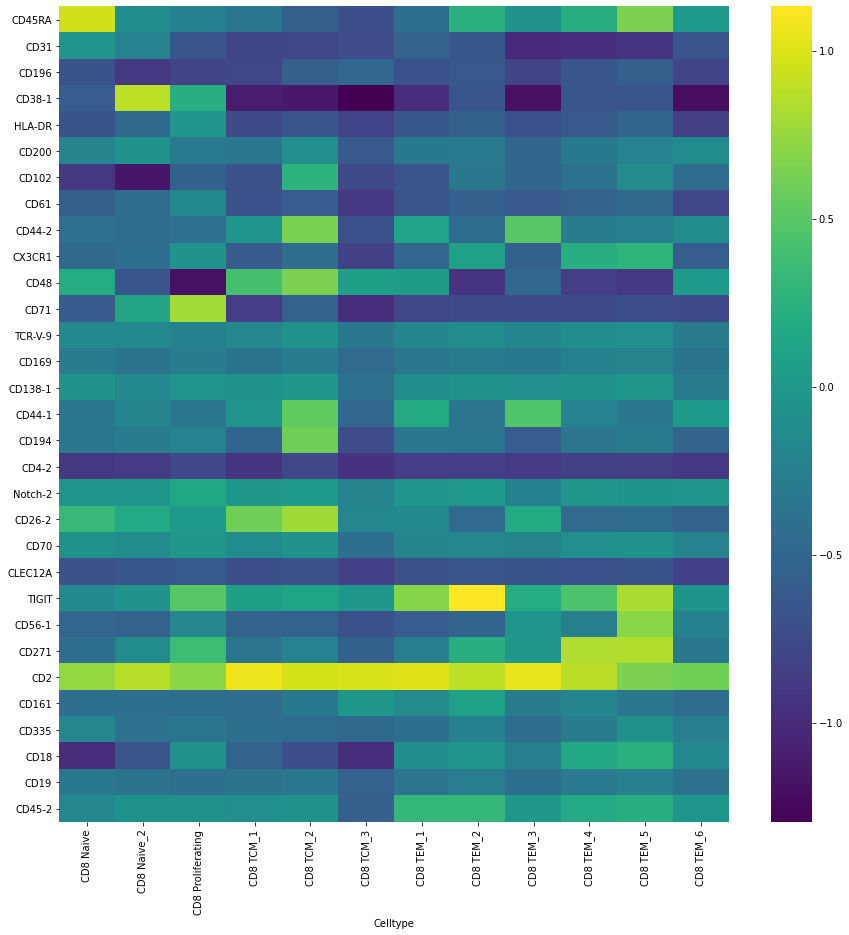

In [8]:
# Heatmap for average protein expression by celltype
fig, ax = plt.subplots(1, 1, figsize = (15, 15))
sns.heatmap(df_protein.groupby('Celltype').mean().T, yticklabels = df_protein.columns[:-1], ax = ax, cmap = 'viridis')

In [9]:
sc.pp.neighbors(tmp_protein_full)
sc.tl.umap(tmp_protein_full)
x, y = tmp_protein_full.obsm['X_umap'].T

In [10]:
sciPENN = sciPENN_API([adata_gene], [adata_protein], adata_gene_test, 
                    train_batchkeys = ['donor'], test_batchkey = 'donor', type_key = 'celltype.l2')

sciPENN.train(n_epochs = 10000, ES_max = 12, decay_max = 6, 
             decay_step = 0.1, lr = 10**(-3), weights_dir = "weights_dir/pbmc_to_pbmc_type", load = False)

Searching for GPU
GPU detected, using GPU

QC Filtering Training Cells
QC Filtering Testing Cells

QC Filtering Training Genes
QC Filtering Testing Genes

Normalizing Training Cells
Normalizing Testing Cells

Log-Normalizing Training Data
Log-Normalizing Testing Data

Finding HVGs


... storing 'orig.ident' as categorical
... storing 'donor' as categorical
... storing 'batch' as categorical
... storing 'Dataset' as categorical
/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)



Normalizing Gene Training Data by Batch


100%|██████████| 4/4 [00:02<00:00,  1.96it/s]



Normalizing Protein Training Data by Batch


100%|██████████| 4/4 [00:01<00:00,  3.84it/s]



Normalizing Gene Testing Data by Batch


100%|██████████| 4/4 [00:02<00:00,  1.67it/s]


Epoch 0 prediction loss = 1.397, validation accuracy = 0.009
Epoch 1 prediction loss = 0.905, validation accuracy = 0.887
Epoch 2 prediction loss = 0.896, validation accuracy = 0.917
Epoch 3 prediction loss = 0.892, validation accuracy = 0.925
Epoch 4 prediction loss = 0.888, validation accuracy = 0.928
Epoch 5 prediction loss = 0.887, validation accuracy = 0.928
Epoch 6 prediction loss = 0.886, validation accuracy = 0.929
Epoch 7 prediction loss = 0.884, validation accuracy = 0.926
Epoch 8 prediction loss = 0.883, validation accuracy = 0.930
Epoch 9 prediction loss = 0.879, validation accuracy = 0.932
Epoch 10 prediction loss = 0.881, validation accuracy = 0.927
Epoch 11 prediction loss = 0.880, validation accuracy = 0.928
Epoch 12 prediction loss = 0.882, validation accuracy = 0.927
Epoch 13 prediction loss = 0.877, validation accuracy = 0.933
Epoch 14 prediction loss = 0.879, validation accuracy = 0.929
Epoch 15 prediction loss = 0.879, validation accuracy = 0.931
Epoch 16 predictio

In [11]:
imputed_test = sciPENN.predict()

In [12]:
imputed_test.obs['transfered cell labels'].to_csv('seurat_to_seuratscipen.csv')

In [13]:
sciPENN = sciPENN_API([adata_gene], [adata_protein], adata_gene_test, 
                    train_batchkeys = ['donor'], test_batchkey = 'donor', type_key = 'celltype.l3')

sciPENN.train(n_epochs = 10000, ES_max = 12, decay_max = 6, 
             decay_step = 0.1, lr = 10**(-3), weights_dir = "weights_dir/pbmc_to_pbmc_typel3", load = False)

Searching for GPU
GPU detected, using GPU

QC Filtering Training Cells
QC Filtering Testing Cells

QC Filtering Training Genes
QC Filtering Testing Genes

Normalizing Training Cells
Normalizing Testing Cells

Log-Normalizing Training Data
Log-Normalizing Testing Data

Finding HVGs


... storing 'orig.ident' as categorical
... storing 'donor' as categorical
... storing 'batch' as categorical
... storing 'Dataset' as categorical
/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)



Normalizing Gene Training Data by Batch


100%|██████████| 4/4 [00:02<00:00,  1.63it/s]



Normalizing Protein Training Data by Batch


100%|██████████| 4/4 [00:01<00:00,  3.67it/s]



Normalizing Gene Testing Data by Batch


100%|██████████| 4/4 [00:02<00:00,  1.45it/s]


Epoch 0 prediction loss = 1.397, validation accuracy = 0.006
Epoch 1 prediction loss = 0.904, validation accuracy = 0.800
Epoch 2 prediction loss = 0.896, validation accuracy = 0.824
Epoch 3 prediction loss = 0.890, validation accuracy = 0.830
Epoch 4 prediction loss = 0.888, validation accuracy = 0.849
Epoch 5 prediction loss = 0.885, validation accuracy = 0.850
Epoch 6 prediction loss = 0.887, validation accuracy = 0.850
Epoch 7 prediction loss = 0.885, validation accuracy = 0.853
Epoch 8 prediction loss = 0.883, validation accuracy = 0.859
Epoch 9 prediction loss = 0.882, validation accuracy = 0.854
Epoch 10 prediction loss = 0.882, validation accuracy = 0.854
Decaying loss to 0.0001
Epoch 11 prediction loss = 0.871, validation accuracy = 0.863
Epoch 12 prediction loss = 0.870, validation accuracy = 0.866
Epoch 13 prediction loss = 0.869, validation accuracy = 0.866
Epoch 14 prediction loss = 0.870, validation accuracy = 0.866
Epoch 15 prediction loss = 0.870, validation accuracy = 

In [14]:
imputed_test = sciPENN.predict()

In [15]:
imputed_test.obs['transfered cell labels'].to_csv('seurat_to_seuratscipenl3.csv')
imputed_test.obs['celltype.l2'].to_csv('true_labels.csv')
imputed_test.obs['celltype.l3'].to_csv('true_labelsl3.csv')

In [16]:
"""Get test data"""

adata_protein_test.X = adata_protein_test.X.toarray()
adata_protein_test.layers["raw"] = adata_protein_test.X

adata_protein_test = adata_protein_test[imputed_test.obs.index]

sc.pp.normalize_total(adata_protein_test)
sc.pp.log1p(adata_protein_test)

common_proteins = np.intersect1d(imputed_test.var.index, adata_protein_test.var.index)

adata_protein_test = adata_protein_test[:, common_proteins]
adata_protein_test.layers['imputed'] = imputed_test[:, common_proteins].X
adata_protein_test.layers.update(imputed_test[:, common_proteins].layers)

patients = np.unique(adata_protein_test.obs['donor'].values)

for patient in patients:
    indices = [x == patient for x in adata_protein_test.obs['donor']]
    sub_adata = adata_protein_test[indices]

    sc.pp.scale(sub_adata)
    adata_protein_test[indices] = sub_adata.X

/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [17]:
def corr2_coeff(A, B, pearson = True):
    if pearson:
        # Rowwise mean of input arrays & subtract from input arrays themeselves
        A_mA = A - A.mean(1)[:, None]
        B_mB = B - B.mean(1)[:, None]

        # Sum of squares across rows
        ssA = (A_mA**2).sum(1)
        ssB = (B_mB**2).sum(1)

        # Finally get corr coeff
        corr_mat = np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None],ssB[None]))
        
        return corr_mat[range(corr_mat.shape[0]), range(corr_mat.shape[0])]
    
    else:
        corrs = [0.] * A.shape[0]
        
        for i in range(A.shape[0]):
            corrs[i] = spearmanr(A[i], B[i])[0]
            
        return corrs

In [18]:
"""Compute correlation across patients"""

corrs = corr2_coeff(adata_protein_test.layers["imputed"].T, adata_protein_test.X.T)
corrs = pd.DataFrame(corrs)
corrs.index = adata_protein_test.var.index
corrs = corrs.dropna()

In [19]:
MSEs= ((adata_protein_test.X - adata_protein_test.layers["imputed"])**2).mean(axis = 0)**(1/2)

protein_table = pd.DataFrame(np.concatenate((corrs.to_numpy(), np.expand_dims(MSEs, axis = 1), adata_protein_test.layers["raw"].mean(axis = 0, keepdims = True).T), axis = 1), 
                             index = corrs.index, columns = ["Correlations", "RMSE", "Mean Expression"])

protein_table["Log-Mean Expression"] = np.log(protein_table["Mean Expression"])

In [20]:
sq = lambda x, y: (x - y)**2

In [21]:
"""Compute correlations within patient"""

corrs_table = np.zeros((adata_protein_test.shape[1], len(np.unique(adata_protein_test.obs["donor"]))))
sq_table = corrs_table.copy()

i = 0
for patient in np.unique(adata_protein_test.obs["donor"]):
    truth = adata_protein_test[adata_protein_test.obs["donor"] == patient].X.copy()
    imputed = adata_protein_test.layers["imputed"][adata_protein_test.obs["donor"] == patient].copy()

    corrs_table[:, i] = corr2_coeff(truth.T, imputed.T)
    sq_table[:, i] = sq(truth, imputed).mean(axis = 0)
    
    i += 1

if np.isnan(corrs_table).sum() > 0:
    corrs_table[np.isnan(corrs_table)] = 0

In [22]:
corrs_table = pd.DataFrame(corrs_table)
corrs_table.index, corrs_table.columns = adata_protein_test.var.index, np.unique(adata_protein_test.obs["donor"])

sq_table = pd.DataFrame(sq_table)
sq_table.index, sq_table.columns = adata_protein_test.var.index, np.unique(adata_protein_test.obs["donor"])

In [23]:
corrs_table.mean(axis = 0)

P2    0.496872
P5    0.497428
P6    0.517123
P8    0.465834
dtype: float64

In [24]:
corrs_table.mean().mean()

0.49431438480210743

In [25]:
sq_table.mean(axis = 0)

P2    0.690795
P5    0.684902
P6    0.668089
P8    0.715904
dtype: float64

In [26]:
sq_table.mean().mean()

0.6899224256464679

In [27]:
r95 = (adata_protein_test.X < adata_protein_test.layers['q75'])
l95 = (adata_protein_test.X > adata_protein_test.layers['q25'])

print(f"Effective Coverage Probability for Nominal 50% PI: {(r95*l95).mean():.3f}")

Effective Coverage Probability for Nominal 50% PI: 0.488


In [28]:
r95 = (adata_protein_test.X < adata_protein_test.layers['q90'])
l95 = (adata_protein_test.X > adata_protein_test.layers['q10'])

print(f"Effective Coverage Probability for Nominal 80% PI: {(r95*l95).mean():.3f}")

Effective Coverage Probability for Nominal 80% PI: 0.792


In [29]:
corrs_table.mean(axis = 0)
corrs_table.mean().mean()

0.49431438480210743

In [30]:
def extract_vector(adata, protein, truth = True):
    tmp = adata_protein_test.copy()
    bools = [x in ['CD14 Mono', 'CD16 Mono', 'cDC2'] for x in tmp.obs['celltype.l2'].values]
    tmp = tmp[bools].copy()
    
    if truth:
        vector = tmp[:, [protein]].X
    else:
        vector = tmp[:, [protein]].layers['imputed']
    
    out = [pd.DataFrame(x.copy()) for x in (vector, tmp.obs['celltype.l2'], tmp.obs['time'])]
    for i in range(len(out)):
        out[i].index = tmp.obs.index
        
    res = pd.concat(out, axis = 1)
    res.columns = ["CD169 Expression", "Celltype", "Time"]
    
    return res
    
df = extract_vector(adata_protein_test, 'CD169')
df

,CD169 Expression,Celltype,Time
index,,,
L1_AAACCCAAGAAACTCA,0.758091,CD14 Mono,7
L1_AAAGAACCAGTATACC,3.373647,CD14 Mono,7
L1_AAAGGATAGTACCATC,0.182252,CD16 Mono,7
L1_AAAGGTATCTTAGTTC,-0.666105,CD14 Mono,0
L1_AAATGGACAAATGGAT,0.574518,CD14 Mono,7
...,...,...,...
E2L8_TTTGGTTCAATGAACA,1.169038,CD14 Mono,3
E2L8_TTTGGTTGTATGGGAC,2.451443,CD14 Mono,3
E2L8_TTTGTTGGTGTGCCTG,1.950854,CD14 Mono,3


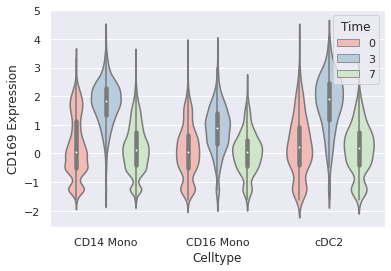

In [31]:
import seaborn as sns
from matplotlib import pyplot

sns.set(style="darkgrid")
 
# Grouped violinplot
sns.violinplot(x = "Celltype", y = "CD169 Expression", hue = "Time", data = df, palette = "Pastel1")
pyplot.show()

df.to_csv("true_CD169.csv")

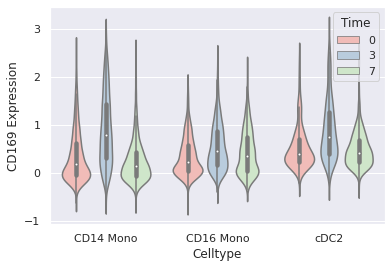

In [32]:
df = extract_vector(adata_protein_test, 'CD169', truth = False)

sns.violinplot(x = "Celltype", y = "CD169 Expression", hue = "Time", data = df, palette = "Pastel1")
pyplot.show()

df.to_csv("scipenn_CD169.csv")

In [33]:
(adata_protein_test.layers['imputed'] < adata_protein_test.X).mean()

ArrayView(0.51865635)

In [34]:
def get_groups(df, celltype):
    df_sub = df[df['Celltype'] == celltype]
    time0 = df_sub[df['Time'] == '0']
    time3 = df_sub[df['Time'] == '3']
    time7 = df_sub[df['Time'] == '7']
    
    return time0['CD169 Expression'], time3['CD169 Expression'], time7['CD169 Expression']

In [35]:
from scipy.stats import kruskal

kruskal(*get_groups(df, 'CD14 Mono'))

/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


KruskalResult(statistic=3482.0437589795915, pvalue=0.0)

In [36]:
kruskal(*get_groups(df, 'CD16 Mono'))

/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


KruskalResult(statistic=126.40775191520497, pvalue=3.5555389183226104e-28)

In [37]:
kruskal(*get_groups(df, 'cDC2'))

/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/home/jlakkis/miniconda3/envs/scipen/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


KruskalResult(statistic=126.40930602841945, pvalue=3.552777136483218e-28)

In [38]:
color_keys = np.unique(tmp_protein.obs['celltype.l3'].values)
color_map = {key: val for key, val in zip(color_keys, pd.read_csv("colors_pbmctypes.csv").iloc[:, 1])}

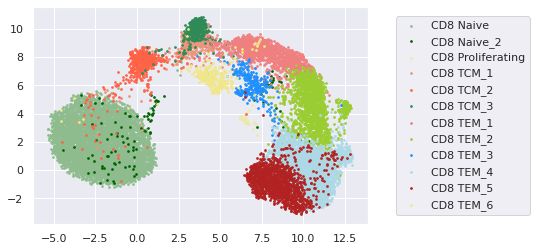

In [39]:
f, ax = plt.subplots(1,1)

for type_ in color_map:
    index = [t == type_ for t in tmp_protein.obs['celltype.l3'].values]
    ax.scatter(x[index], y[index], label = type_, c = color_map[type_], marker='.', s = 30, linewidths=0)

ax.legend(loc = 'right', bbox_to_anchor=(1.5, 0.5))

In [40]:
tmp_gene.write('scipenn_gene_pbmctopbmc.h5ad')
adata_protein_test.write('scipenn_protein_pbmctopbmc.h5ad')

In [41]:
gene_map = {protein: gene for protein, gene in zip(proteins, genes)}
normalize = lambda vec: (vec - vec.min())/(vec.max() - vec.min())

def plot_protein(protein):
    gene = gene_map[protein]
    
    f, axs = plt.subplots(1, 3, figsize = (15, 5))
    
    expr = tmp_gene[:, gene].X[:, 0].toarray()
    axs[0].scatter(x, y, c = normalize(expr), marker='.', s = 10, linewidths=0, cmap = 'viridis')
    axs[0].set_title(f'RNA: {gene}')
    
    type_key = [x in cd8_types for x in adata_protein_test.obs['celltype.l3']]
    
    expr = adata_protein_test[type_key, protein].X[:, 0].toarray()
    axs[1].scatter(x, y, c = normalize(expr), marker='.', s = 10, linewidths=0, cmap = 'viridis')
    axs[1].set_title(f'True Protein: {protein}')
    
    pred_expr = adata_protein_test[type_key, protein].layers['imputed'].reshape((-1,))
    axs[2].scatter(x, y, c = normalize(pred_expr), marker='.', s = 10, linewidths=0, cmap = 'viridis')
    axs[2].set_title(f'Predicted Protein: {protein}')
    
    PCM = axs[2].get_children()[0]

    cb_ax = f.add_axes([0.92, 0.1, 0.01, 0.8])
    cbar = f.colorbar(PCM, cax=cb_ax)

In [42]:
data = adata_protein_test[type_key]

def find_best_proteins(ctypes):
    array = data.X.copy()
    bool_vec = np.asarray([[int(x == ctype) for x in data.obs['celltype.l3']] for ctype in ctypes]).T
    
    EX = array.mean(axis = 0)
    EY = bool_vec.mean(axis = 0)
    EXY = (array[:, :, None] * bool_vec[:, None]).mean(axis = 0)
    EX2 = (array ** 2).mean(axis = 0)
    
    COV = EXY - EX[:, None] * EY[None]
    VX = EX2 - EX**2
    VY = EY - EY**2
    
    corrs = COV/(VX[:, None] * VY[None])**(0.5)
        
    return data.var.index[corrs.argmax(axis = 0)].tolist()

In [43]:
ctypes = adata_protein_test[type_key].obs['celltype.l3'].value_counts().index.tolist()
{ctype: protein for ctype, protein in zip(ctypes, find_best_proteins(ctypes))}

{'CD8 Naive': 'CD55',
 'CD8 TEM_4': 'CD43',
 'CD8 TEM_2': 'CD244',
 'CD8 TEM_5': 'CD56-2',
 'CD8 TEM_1': 'CD45RO',
 'CD8 TCM_2': 'CD25',
 'CD8 TCM_1': 'CD49a',
 'CD8 TCM_3': 'CD103',
 'CD8 TEM_6': 'CD305',
 'CD8 TEM_3': 'CD195',
 'CD8 Naive_2': 'CD38-1',
 'CD8 Proliferating': 'CD71'}

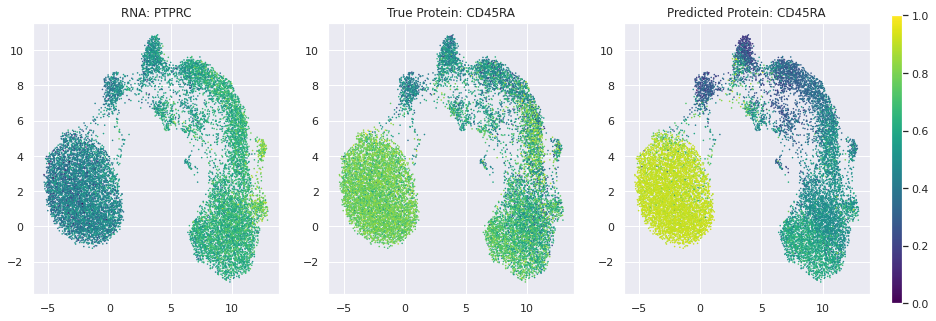

In [44]:
plot_protein('CD45RA')

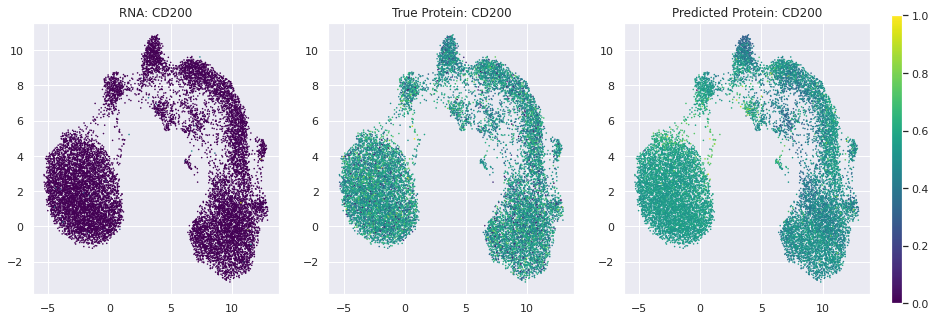

In [45]:
plot_protein('CD200')

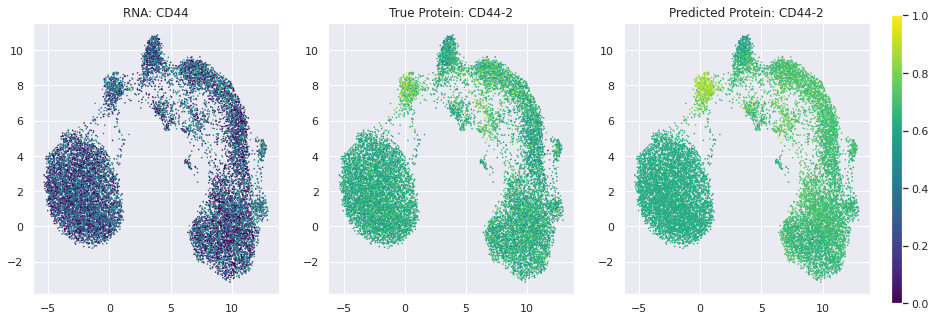

In [46]:
plot_protein('CD44-2')

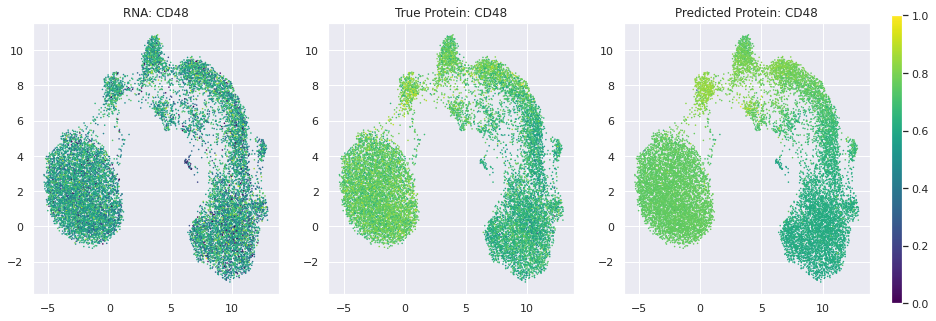

In [47]:
plot_protein('CD48')

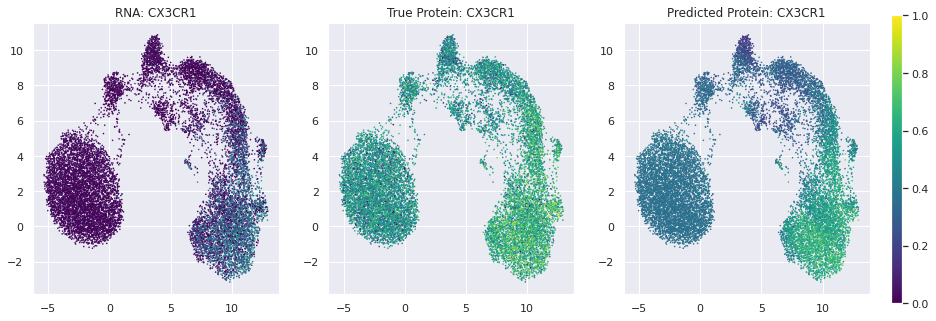

In [48]:
plot_protein('CX3CR1')

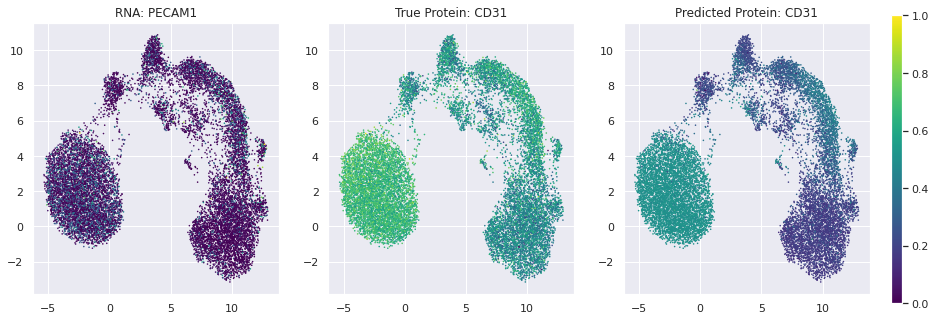

In [49]:
plot_protein('CD31')

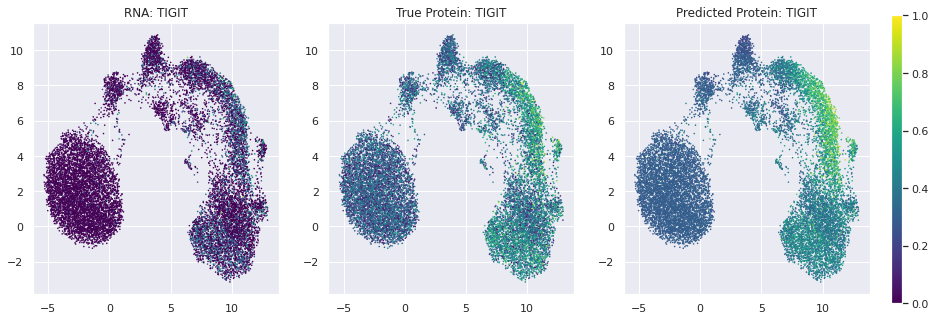

In [50]:
plot_protein('TIGIT')

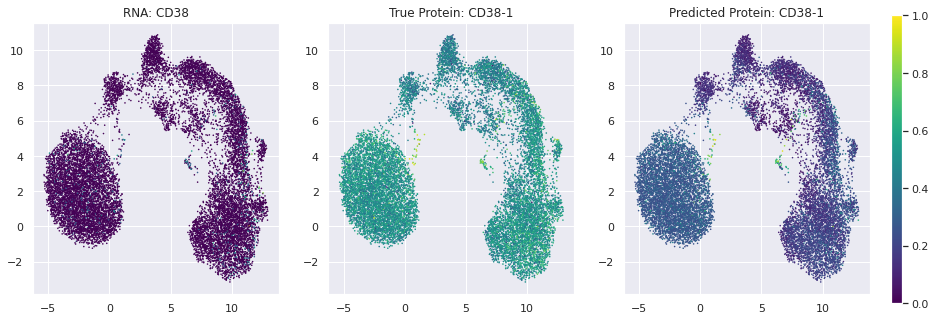

In [51]:
plot_protein('CD38-1')

In [52]:
means = {prt: val for prt, val in zip(adata_protein_test.var.index, adata_protein_test.layers['raw'].mean(axis = 0))}

means['CD45RA'], means['CD38-1'], means['CD71'], means['TIGIT']

(18.879057, 41.442284, 26.13193, 2.2537007)